In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/English_data.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')


In [71]:
# Constants
IMAGE_SIZE = 124
CHANNELS = 3

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well
TEST_SIZE = 0.2
ALPHA = 0.001
EPOCHS = 500 # number of cycles to run
PATIENCE = 20
LR_PATIENCE = 20
FACTOR_LR = 0.5
BATCH_SIZE = 32 # inline of Training Rows being 60000


In [72]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(

#     "English_data",

#     seed=123,

#     shuffle=True,

#     image_size=(IMAGE_SIZE, IMAGE_SIZE),

#     batch_size=BATCH_SIZE

# )


In [73]:
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    "English_data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE
)
# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    "English_data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE,
)

Found 7525 files belonging to 315 classes.
Using 6020 files for training.
Found 7525 files belonging to 315 classes.
Using 1505 files for validation.


In [74]:

# train_datagen = ImageDataGenerator(
#     rescale=1./255,  # Normalize pixel values
#     width_shift_range=0.2,  # Random horizontal shift
#     height_shift_range=0.2,  # Random vertical shift
#     shear_range=0.2,  # Random shear
#     zoom_range=0.2,  # Random zoom
#     rotation_range=20,  # Random rotation
#     fill_mode='nearest'  # Fill mode for padding
# )

# train_augmented_ds = train_datagen.flow_from_directory(
#     "English_data",
#     target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

In [75]:


train_ds = train_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, 315)))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (x / 255.0, tf.one_hot(y, 315)))

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# **InceptionResNetV2**

In [76]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model

# Define the InceptionResNetV2 model with random weights
base_model = InceptionResNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
                                include_top=False,
                                weights="imagenet",pooling='max')


# Build the new model
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(315, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)




In [77]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True,
    verbose = 1)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)


In [80]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=test_ds,
                    epochs=150,
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_callback, lr_decay]
                   )

Epoch 1/150
189/189 [==============================] - 195s 261ms/step - loss: 4.7834 - accuracy: 0.1179 - val_loss: 46.3556 - val_accuracy: 0.0844 - lr: 0.0010
Epoch 2/150
189/189 [==============================] - 44s 233ms/step - loss: 1.6961 - accuracy: 0.5520 - val_loss: 1.0132 - val_accuracy: 0.6811 - lr: 0.0010
Epoch 3/150
189/189 [==============================] - 41s 219ms/step - loss: 0.4613 - accuracy: 0.8623 - val_loss: 0.5224 - val_accuracy: 0.8465 - lr: 0.0010
Epoch 4/150
130/189 [===================>..........] - ETA: 11s - loss: 0.1762 - accuracy: 0.9514

In [14]:
model_save_path = '/content/drive/My Drive/MyModels/InceptionResNetV2_max.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/MyModels/my_model.h5


Saving set6_p21.png to set6_p21.png


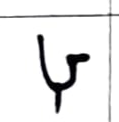

In [48]:
import numpy as np
from PIL import Image
from IPython.display import display
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  display(Image.open(fn))


In [49]:
# Assuming the uploaded file is 'my_image.jpg'
img_path = 'set6_p21.png'
img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)


In [50]:
predictions = model.predict(img_array)


1/1 [==============================] - 0s 24ms/step


In [51]:
labels[np.argmax(predictions)]

'hu'

In [24]:
for x,y in train_ds:
  print(y)
  break

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 315), dtype=float32)


In [32]:
labels = os.listdir("/content/English_data")

In [30]:
import os

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                8388672   
                                                                 
 dense_3 (Dense)             (None, 315)               20475     
                                                                 
Total params: 31996859 (122.06 MB)
Trainable params: 8409147 (32.08 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
